In [9]:
import pandas as pd
import numpy as np
import time
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import randint, uniform

import sys
sys.path.append('../')
from backtest_functions_v2 import *

In [10]:
# Load the latest dataset
df = pd.read_parquet("../data/full_dataset_feature_engineering_v3.parquet")
print("Dataset loaded successfully.")
df.info()

Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35058 entries, 2021-01-01 06:00:00 to 2024-12-31 23:00:00
Columns: 149 entries, news_count to reddit_average_sentiment_ewm_100h
dtypes: float64(87), int32(1), int64(61)
memory usage: 40.0 MB


### Data Preparation and Splitting

In [11]:
# Manual feature selection: use only sentiment features
selected_features = [
  'news_count',
  'tanalysis_absa_ewm_100h', 'economy_absa_ewm_100h',
  'regulation_absa_ewm_100h', 'technology_absa_ewm_100h',
  'adoption_absa_ewm_100h', 'cybersecurity_absa_ewm_100h',
  'reddit_total_sentiment_ewm_2h',
  'reddit_average_sentiment_ewm_100h'
]

# Define training (2021-2023) and testing (2024) periods
df_train = df[df['year'].isin([2021, 2022, 2023])]
df_test = df[df['year'] == 2024]

X_train = df_train[selected_features]
y_train = df_train['target']
X_test = df_test[selected_features]
y_test = df_test['target']

# Print shapes and class distribution
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

X_train shape: (26274, 9)
y_train shape: (26274,)
X_test shape: (8784, 9)
y_test shape: (8784,)
Training set class distribution: [ 9993  6038 10243]
Test set class distribution: [2648 3274 2862]


### XGBoost Model with RandomizedSearchCV

In [12]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('model', xgb.XGBClassifier(
    objective='multi:softprob', # Output probabilities for each class
    eval_metric='mlogloss',     # Logloss for multiclass classification
    random_state=42,
    n_jobs=-1
  ))
])

# Parameter distributions for RandomizedSearchCV
param_distributions = {
  'model__n_estimators': randint(100, 500),
  'model__max_depth': randint(3, 10),
  'model__learning_rate': uniform(0.005, 0.2),
  'model__subsample': uniform(0.6, 0.4),
  'model__colsample_bytree': uniform(0.6, 0.4),

  # Regularization parameters:
  'model__gamma': uniform(0, 1),
  'model__reg_alpha': uniform(0, 1), # Continuous distribution for L1 reg
  'model__reg_lambda': uniform(0, 2) # Continuous distribution for L2 reg (starting from 1)
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Compute sample weights for handling class imbalance during fitting
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
fit_params = {'model__sample_weight': sample_weights}

# Initialize RandomizedSearchCV
n_iterations = 200
random_search = RandomizedSearchCV(
  estimator=pipeline,
  param_distributions=param_distributions,
  n_iter=n_iterations,
  cv=tscv,
  scoring='roc_auc_ovr_weighted',
  n_jobs=-1,
  verbose=1,
  random_state=42 # For reproducibility of the search
)

# Fit RandomizedSearchCV on the training data
print(f"Starting RandomizedSearchCV for XGBoostClassifier ({n_iterations} iterations)...")
start_time = time.time()
# Pass fit_params to the fit method
random_search.fit(X_train, y_train, **fit_params)
end_time = time.time()

print(f"\nRandomizedSearchCV fitting time: {end_time - start_time:.2f} seconds")
print("Best parameters found: ")
pprint(random_search.best_params_)
print("\nBest cross-validation ROC AUC score: ", random_search.best_score_)

# Get the best estimator found by RandomizedSearchCV
best_model = random_search.best_estimator_

Starting RandomizedSearchCV for XGBoostClassifier (200 iterations)...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits

RandomizedSearchCV fitting time: 196.51 seconds
Best parameters found: 
{'model__colsample_bytree': 0.845364555684283,
 'model__gamma': 0.16703394609207523,
 'model__learning_rate': 0.20323372522739533,
 'model__max_depth': 5,
 'model__n_estimators': 171,
 'model__reg_alpha': 0.9427317741351257,
 'model__reg_lambda': 1.299293297984737,
 'model__subsample': 0.8430947179515437}

Best cross-validation ROC AUC score:  0.5127131915499226


### Feature Importance Analysis


Top 20 most important features:
                             Feature  Importance
3           regulation_absa_ewm_100h    0.122598
5             adoption_absa_ewm_100h    0.121168
8  reddit_average_sentiment_ewm_100h    0.120870
1            tanalysis_absa_ewm_100h    0.118484
2              economy_absa_ewm_100h    0.109554
6        cybersecurity_absa_ewm_100h    0.107298
4           technology_absa_ewm_100h    0.103826
7      reddit_total_sentiment_ewm_2h    0.103032
0                         news_count    0.093170


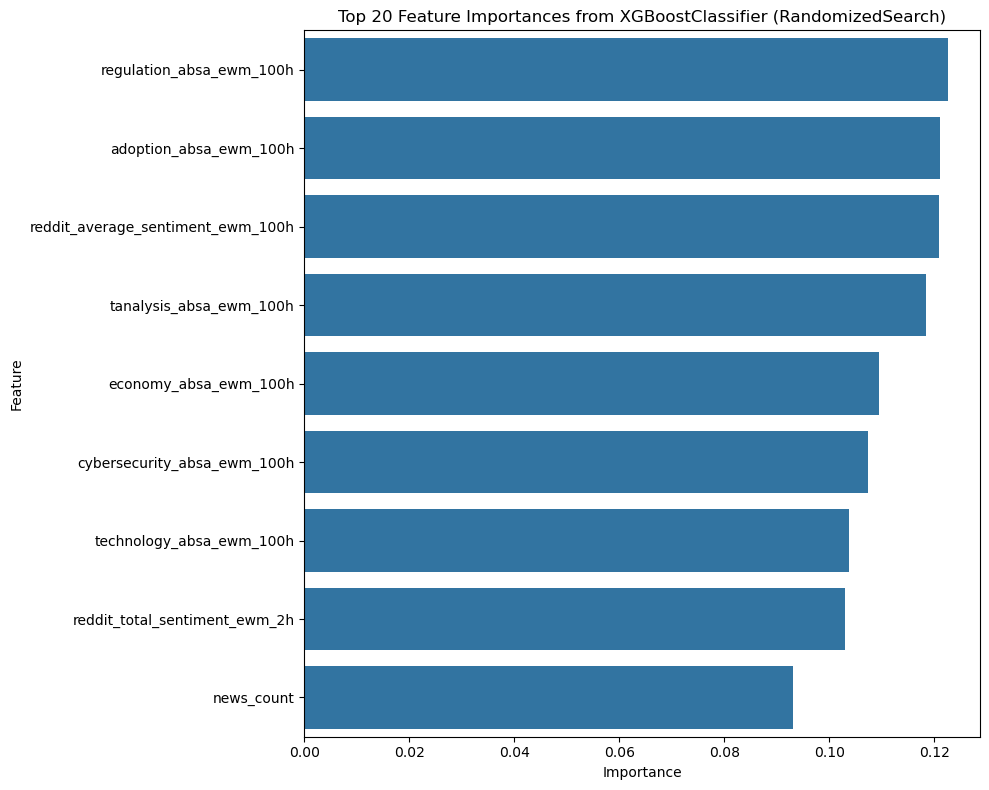

In [13]:
# Get feature importances from the best XGBoost model
importances = best_model.named_steps['model'].feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nTop 20 most important features:")
print(importance_df.head(20))

# Plot top 20 feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances from XGBoostClassifier (RandomizedSearch)')
plt.tight_layout()
plt.show()

### Model Evaluation on Test Set


Predicting on the test set...
Prediction complete.

Test Set Evaluation:
Accuracy: 0.3548
ROC AUC Score (One-vs-Rest): 0.5304

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.32      0.30      0.31      2648
 Neutral (1)       0.42      0.37      0.40      3274
 Bullish (2)       0.32      0.38      0.35      2862

    accuracy                           0.35      8784
   macro avg       0.35      0.35      0.35      8784
weighted avg       0.36      0.35      0.36      8784


Confusion Matrix:
[[ 804  797 1047]
 [ 812 1227 1235]
 [ 862  914 1086]]


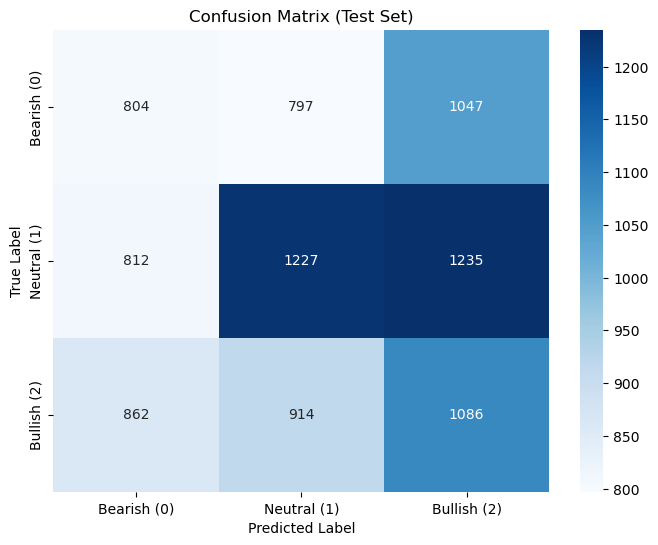

In [14]:
# Make predictions on the test set
print("\nPredicting on the test set...")
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)
print("Prediction complete.")

# Evaluate the model performance on the test set
accuracy = accuracy_score(y_test, y_pred)
class_names = ['Bearish (0)', 'Neutral (1)', 'Bullish (2)']
report = classification_report(y_test, y_pred, target_names=class_names)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"\nTest Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score (One-vs-Rest): {roc_auc:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

### Monthly Accuracy Analysis


Monthly Accuracy (2024 Test Set):
2024-01-31    0.364247
2024-02-29    0.366379
2024-03-31    0.388441
2024-04-30    0.322222
2024-05-31    0.348118
2024-06-30    0.320833
2024-07-31    0.307796
2024-08-31    0.360215
2024-09-30    0.331944
2024-10-31    0.313172
2024-11-30    0.456944
2024-12-31    0.379032
Freq: ME, Name: correct_prediction, dtype: float64


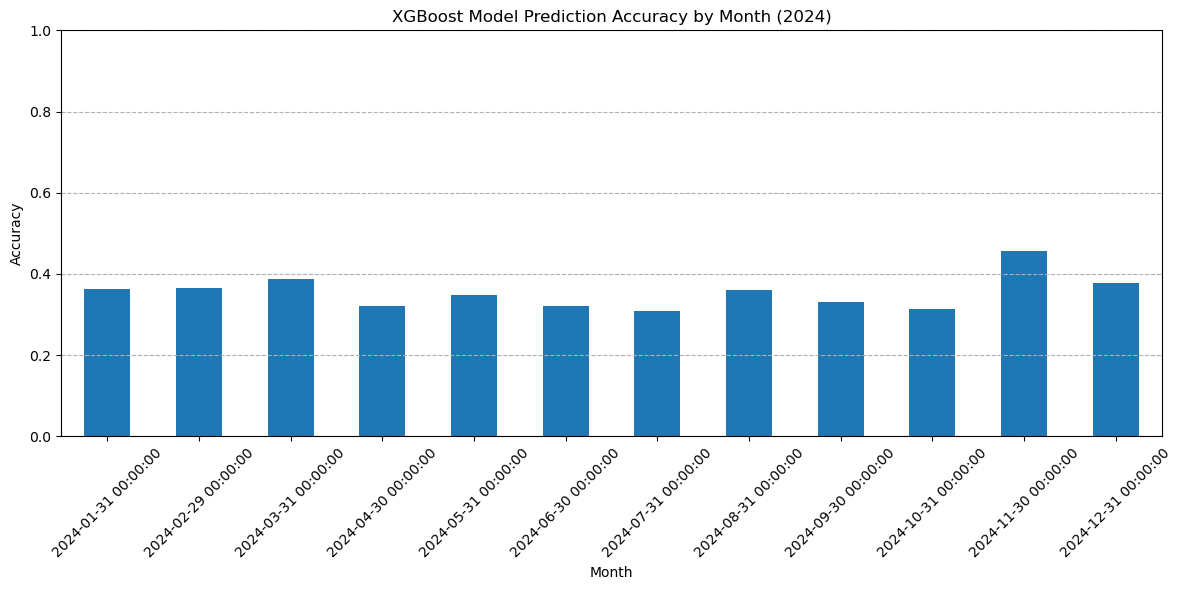


Sample of Test Results with Predictions:
                     target  predicted_class actual_label predicted_label  \
2024-01-01 00:00:00       0                0      Bearish         Bearish   
2024-01-01 01:00:00       1                0      Neutral         Bearish   
2024-01-01 02:00:00       0                1      Bearish         Neutral   
2024-01-01 03:00:00       1                0      Neutral         Bearish   
2024-01-01 04:00:00       2                0      Bullish         Bearish   

                     prob_bearish  prob_neutral  prob_bullish  
2024-01-01 00:00:00      0.451971      0.222886      0.325144  
2024-01-01 01:00:00      0.384307      0.239183      0.376510  
2024-01-01 02:00:00      0.351422      0.366928      0.281650  
2024-01-01 03:00:00      0.384480      0.331462      0.284058  
2024-01-01 04:00:00      0.375892      0.286785      0.337323  


In [15]:
# Add predictions and probabilities to the test dataframe for analysis
df_test_results = df_test.copy()

df_test_results.loc[:, 'predicted_class'] = y_pred
df_test_results.loc[:, 'prob_bearish'] = y_pred_proba[:, 0]
df_test_results.loc[:, 'prob_neutral'] = y_pred_proba[:, 1]
df_test_results.loc[:, 'prob_bullish'] = y_pred_proba[:, 2]

# Map numerical target/prediction to labels for clarity
target_map = {0: 'Bearish', 1: 'Neutral', 2: 'Bullish'}
df_test_results.loc[:, 'actual_label'] = df_test_results['target'].map(target_map)
df_test_results.loc[:, 'predicted_label'] = df_test_results['predicted_class'].map(target_map)

# Calculate if the prediction was correct
df_test_results.loc[:, 'correct_prediction'] = (df_test_results['target'] == df_test_results['predicted_class']).astype(int)

# --- Monthly Accuracy Analysis ---
if isinstance(df_test_results.index, pd.DatetimeIndex):
    # Ensure the index is timezone-naive or handle conversion if necessary
    if df_test_results.index.tz is not None:
        df_test_results.index = df_test_results.index.tz_localize(None)
        
    monthly_accuracy = df_test_results.resample('ME')['correct_prediction'].mean()
    
    print("\nMonthly Accuracy (2024 Test Set):")
    print(monthly_accuracy)
    
    plt.figure(figsize=(12, 6))
    monthly_accuracy.plot(kind='bar')
    plt.title('XGBoost Model Prediction Accuracy by Month (2024)')
    plt.ylabel('Accuracy')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    plt.ylim(0, 1) # Set y-axis limits for better comparison
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print("Index is not DatetimeIndex. Skipping monthly accuracy plot.")

# Display some results
print("\nSample of Test Results with Predictions:")
print(df_test_results[['target', 'predicted_class', 'actual_label', 'predicted_label', 'prob_bearish', 'prob_neutral', 'prob_bullish']].head())

### Backtesting the Strategy

Sample signals for backtesting:
                     target  predicted_class  signal
2024-01-01 00:00:00       0                0      -1
2024-01-01 01:00:00       1                0      -1
2024-01-01 02:00:00       0                1       0
2024-01-01 03:00:00       1                0      -1
2024-01-01 04:00:00       2                0      -1

Predicted signal distribution for backtest:
signal
 1    3368
 0    2938
-1    2478
Name: count, dtype: int64
Overall Annual Return: 50.84%
Overall Annual Sharpe Ratio: 1.1308
Maximum Drawdown: -53.09 %
Alpha: 0.5888
Beta: 0.0551

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.508366    0.454796     0.055116      0.462977       1.130802


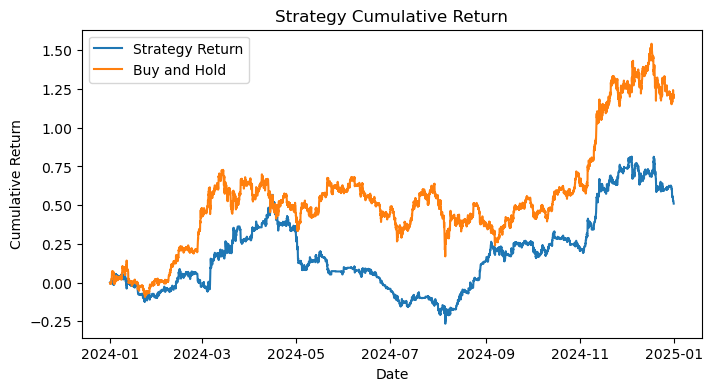

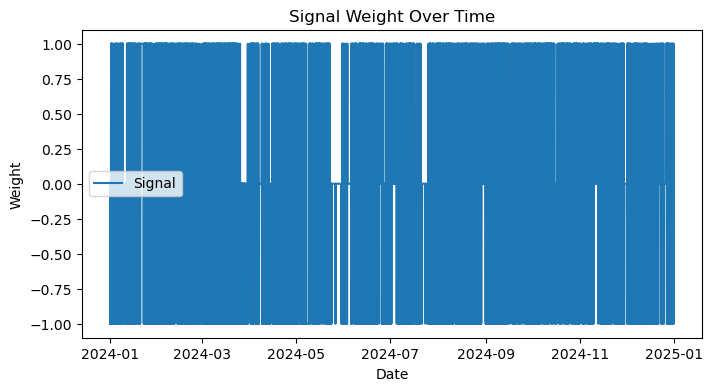

In [16]:
# Prepare dataframe for backtesting
df_backtest = df_test_results.copy()

# Map predicted class to trading signal: 0 -> -1 (Short), 1 -> 0 (Neutral), 2 -> 1 (Long)
df_backtest['signal'] = df_backtest['predicted_class'] - 1

# Display the first few rows with the new signal column
print("Sample signals for backtesting:")
print(df_backtest[['target', 'predicted_class', 'signal']].head())

# Check the distribution of the generated signals
print("\nPredicted signal distribution for backtest:")
print(df_backtest['signal'].value_counts())


run_backtest(df_backtest, freq='h')